In [1]:
#Installation of extra package required:
#conda install -c anaconda py-xgboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, zero_one_loss, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score, auc, matthews_corrcoef
from sklearn.metrics import roc_curve, average_precision_score, precision_recall_curve, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.feature_selection import RFE

from imblearn.over_sampling import SMOTE 

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from mlxtend.classifier import OneRClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Task 1
***

In [3]:
#Import the csv into a pandas dataframe
dataset = pd.read_csv("heart_failure_clinical_records_dataset.csv", header=0)
X = dataset.drop(['DEATH_EVENT', 'time'], axis=1)
y = dataset['DEATH_EVENT']

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [5]:
#Create different functions to handle repitition of the various classifiers.
repeat = 100

def run_model(InClf):
    accuracy_agg = 0
    f1_agg = 0
    MCC_agg = 0
    TP_agg = 0
    TN_agg = 0
    ROC_AUC_agg = 0
    PR_AUC_agg = 0
    for x in range(repeat):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
        
        InClf.fit(X_train.values, y_train)
        y_pred = InClf.predict(X_test.values)

        accuracy_agg = accuracy_agg + accuracy_score(y_test, y_pred)
        f1_agg = f1_agg + f1_score(y_test, y_pred)
        MCC_agg = MCC_agg + matthews_corrcoef(y_test, y_pred)
        precision_auc, recall_auc, thresholds = precision_recall_curve(y_test, y_pred)
        PR_AUC_agg = PR_AUC_agg + auc(recall_auc, precision_auc)
        y_roc = InClf.predict_proba(X_test.values)
        y_roc = y_roc[:,1]
        ROC_AUC_agg = ROC_AUC_agg + roc_auc_score(y_test, y_roc)
        
        CM = pd.DataFrame(confusion_matrix(y_test, y_pred))
        TP_agg = TP_agg + CM[1][1] / (CM[1][1] + CM[0][1])
        TN_agg = TN_agg + (CM[0][0]) / (CM[0][0] + CM[1][0])

    print("MCC:", MCC_agg/repeat)
    print("F1 score:", f1_agg/repeat)
    print("Accuracy:", accuracy_agg/repeat)
    print("TP:", TP_agg/repeat)
    print("TN:", TN_agg/repeat)
    print("PR AUC:", PR_AUC_agg/repeat)
    print("ROC AUC", ROC_AUC_agg/repeat)
    print("")
    
def run_tuned_model(InClf):
    accuracy_agg = 0
    f1_agg = 0
    MCC_agg = 0
    TP_agg = 0
    TN_agg = 0
    ROC_AUC_agg = 0
    PR_AUC_agg = 0
    
    MMS = StandardScaler()
    
    for x in range(repeat):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
        InClf.fit(X_train.values, y_train)
        y_pred = clf.predict(X_test.values)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y)
        X_test, X_validate, y_test, y_validate = train_test_split(X_test, y_test, test_size = .5, stratify=y_test) 
        MMS.fit(X_train)
        X_train = MMS.transform(X_train)
        X_test = MMS.transform(X_test)
        InClf.fit(X_train, y_train)
        y_pred = InClf.predict(X_test)

        accuracy_agg = accuracy_agg + accuracy_score(y_test, y_pred)
        f1_agg = f1_agg + f1_score(y_test, y_pred)
        MCC_agg = MCC_agg + matthews_corrcoef(y_test, y_pred)
        precision_auc, recall_auc, thresholds = precision_recall_curve(y_test, y_pred)
        PR_AUC_agg = PR_AUC_agg + auc(recall_auc, precision_auc)
        y_roc = InClf.predict_proba(X_test)
        y_roc = y_roc[:,1]
        ROC_AUC_agg = ROC_AUC_agg + roc_auc_score(y_test, y_roc)
        CM = pd.DataFrame(confusion_matrix(y_test, y_pred))
        TP_agg = TP_agg + CM[1][1] / (CM[1][1] + CM[0][1])
        TN_agg = TN_agg + (CM[0][0]) / (CM[0][0] + CM[1][0])

    print("MCC:", MCC_agg/repeat)
    print("F1 score:", f1_agg/repeat)
    print("Accuracy:", accuracy_agg/repeat)
    print("TP:", TP_agg/repeat)
    print("TN:", TN_agg/repeat)
    print("PR AUC:", PR_AUC_agg/repeat)
    print("ROC AUC", ROC_AUC_agg/repeat)
    print("")
    
def run_model_alt_ROC(InClf):
    accuracy_agg = 0
    f1_agg = 0
    MCC_agg = 0
    TP_agg = 0
    TN_agg = 0
    ROC_AUC_agg = 0
    PR_AUC_agg = 0
    for x in range(repeat):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
        InClf.fit(X_train.values, y_train)
        y_pred = InClf.predict(X_test.values)

        accuracy_agg = accuracy_agg + accuracy_score(y_test, y_pred)
        f1_agg = f1_agg + f1_score(y_test, y_pred)
        MCC_agg = MCC_agg + matthews_corrcoef(y_test, y_pred)
        precision_auc, recall_auc, thresholds = precision_recall_curve(y_test, y_pred)
        PR_AUC_agg = PR_AUC_agg + auc(recall_auc, precision_auc)
        ROC_AUC_agg = ROC_AUC_agg + roc_auc_score(y_test, y_pred)
        
        CM = pd.DataFrame(confusion_matrix(y_test, y_pred))
        TP_agg = TP_agg + CM[1][1] / (CM[1][1] + CM[0][1])
        TN_agg = TN_agg + (CM[0][0]) / (CM[0][0] + CM[1][0])

    print("MCC:", MCC_agg/repeat)
    print("F1 score:", f1_agg/repeat)
    print("Accuracy:", accuracy_agg/repeat)
    print("TP:", TP_agg/repeat)
    print("TN:", TN_agg/repeat)
    print("PR AUC:", PR_AUC_agg/repeat)
    print("ROC AUC", ROC_AUC_agg/repeat)
    print("")
    
def run_tuned_model_alt_ROC(InClf):
    accuracy_agg = 0
    f1_agg = 0
    MCC_agg = 0
    TP_agg = 0
    TN_agg = 0
    ROC_AUC_agg = 0
    PR_AUC_agg = 0
    
    SS = StandardScaler()
    
    for x in range(repeat):        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y)
        X_test, X_validate, y_test, y_validate = train_test_split(X_test, y_test, test_size = .5, stratify=y_test)
        SS.fit(X_train)
        X_train = SS.transform(X_train)
        X_test = SS.transform(X_test)
        InClf.fit(X_train, y_train)
        y_pred = InClf.predict(X_test)

        accuracy_agg = accuracy_agg + accuracy_score(y_test, y_pred)
        f1_agg = f1_agg + f1_score(y_test, y_pred)
        MCC_agg = MCC_agg + matthews_corrcoef(y_test, y_pred)
        precision_auc, recall_auc, thresholds = precision_recall_curve(y_test, y_pred)
        PR_AUC_agg = PR_AUC_agg + auc(recall_auc, precision_auc)
        ROC_AUC_agg = ROC_AUC_agg + roc_auc_score(y_test, y_pred)
        CM = pd.DataFrame(confusion_matrix(y_test, y_pred))
        TP_agg = TP_agg + CM[1][1] / (CM[1][1] + CM[0][1])
        TN_agg = TN_agg + (CM[0][0]) / (CM[0][0] + CM[1][0])

    print("MCC:", MCC_agg/repeat)
    print("F1 score:", f1_agg/repeat)
    print("Accuracy:", accuracy_agg/repeat)
    print("TP:", TP_agg/repeat)
    print("TN:", TN_agg/repeat)
    print("PR AUC:", PR_AUC_agg/repeat)
    print("ROC AUC", ROC_AUC_agg/repeat)
    print("")

In [6]:
#Run all of the classifiers and create output metrics.
print("Random Forest")
clf = RandomForestClassifier(n_jobs=-1)
run_model(clf)

print("Decision Tree")
clf = DecisionTreeClassifier(criterion='gini', min_samples_split=20, min_samples_leaf=int(round(20.0/3.0)), max_depth=30)
run_model(clf)

print("XGBoost")
clf = xgb.XGBClassifier(max_depth=2, num_round=2, nthread=2, eta=1)
run_model(clf)

print("Linear Regression")
clf = RidgeClassifier(alpha=0)
run_model_alt_ROC(clf)

print("One Rule")
clf = OneRClassifier()
run_model_alt_ROC(clf)

print("One Rule - Decision Stump Substitution")
clf = DecisionTreeClassifier(criterion='entropy', max_depth=1)
run_model(clf)

print("Naive Bayes")
clf = GaussianNB()
run_model(clf)

print("Artificial Neural Network")
clf = MLPClassifier(hidden_layer_sizes=(100))
run_tuned_model(clf)

print("SVC - Radial")
clf = SVC(C=10, kernel='rbf', cache_size=40)
run_tuned_model_alt_ROC(clf)

print("SVC - linear")
clf = LinearSVC(C=0.1)
run_tuned_model_alt_ROC(clf)

print("K-Nearest Neighbor")
clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=3)
run_tuned_model(clf)

Random Forest
MCC: 0.34718390067247407
F1 score: 0.5093362320453401
Accuracy: 0.7333333333333333
TP: 0.44526315789473697
TN: 0.8668292682926836
PR AUC: 0.6186649127022377
ROC AUC 0.7815789473684208

Decision Tree
MCC: 0.3777175721427944
F1 score: 0.549488341661693
Accuracy: 0.7391666666666664
TP: 0.5115789473684209
TN: 0.8446341463414635
PR AUC: 0.6395334292900086
ROC AUC 0.7489730423620025

XGBoost
MCC: 0.36825714638960766
F1 score: 0.5309153568194875
Accuracy: 0.7395
TP: 0.47526315789473683
TN: 0.8619512195121958
PR AUC: 0.6326886851968123
ROC AUC 0.7607445442875485

Linear Regression
MCC: 0.34636827512170115
F1 score: 0.4901608747182551
Accuracy: 0.7375
TP: 0.40421052631578935
TN: 0.8919512195121955
PR AUC: 0.6184203405383744
ROC AUC 0.6480808729139922

One Rule
MCC: -0.06656392722531351
F1 score: 0.04039721872330568
Accuracy: 0.6526666666666663
TP: 0.024210526315789474
TN: 0.9439024390243904
PR AUC: 0.28623621553884754
ROC AUC 0.48405648267008994

One Rule - Decision Stump Substitu

# Task 2:
***
***

In [7]:
#Import the csv into a pandas dataframe
dataset = pd.read_csv("heart_failure_clinical_records_dataset.csv", header=0)

# X = dataset.drop(['DEATH_EVENT', 'diabetes', 'sex', 'high_blood_pressure', 'smoking'], axis=1)
X = dataset.drop(['DEATH_EVENT'], axis=1)
y = dataset['DEATH_EVENT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, stratify=y)

##### Preliminary Data Analysis and Investigations
***

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [9]:
dataset.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


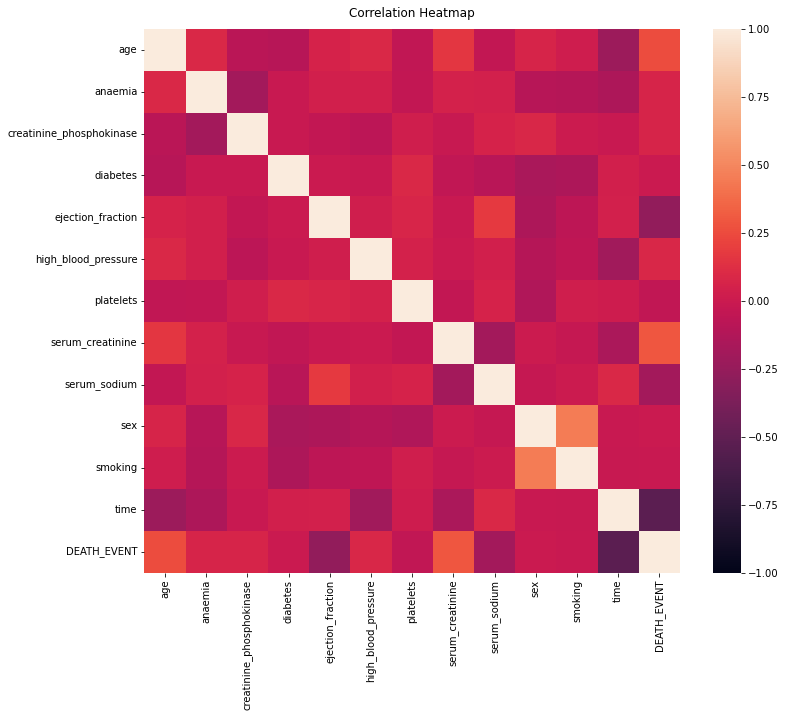

In [10]:
#Check for correlations in features - visualisation
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(dataset.corr(), vmin=-1, vmax=1, annot=False, xticklabels = 1, yticklabels = 1)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

In [11]:
#Check for correlations in the features
corr_matrix = dataset.corr()
print(corr_matrix["DEATH_EVENT"].sort_values(ascending=False))

DEATH_EVENT                 1.000000
serum_creatinine            0.294278
age                         0.253729
high_blood_pressure         0.079351
anaemia                     0.066270
creatinine_phosphokinase    0.062728
diabetes                   -0.001943
sex                        -0.004316
smoking                    -0.012623
platelets                  -0.049139
serum_sodium               -0.195204
ejection_fraction          -0.268603
time                       -0.526964
Name: DEATH_EVENT, dtype: float64


In [12]:
#Create a function to check outliers using IQR rule.
def outlier(invar):
    QT1 = dataset[invar].quantile(.25)
    QT3 = dataset[invar].quantile(.75)
    Feature_min = dataset[invar].min()
    Feature_max = dataset[invar].max()
    IQR = QT3 - QT1
    Outlier_IQR = IQR * 1.5
    outlier_min = QT1 - Outlier_IQR
    outlier_max = QT3 + Outlier_IQR
    print(invar)
    print('Min outlier threshhold: ', outlier_min)
    print('Max outlier threshhold: ', outlier_max)
    print('Feature minimum: ', Feature_min)
    print('Feature maximum value: ', Feature_max)
    print("")

outlier('creatinine_phosphokinase')
outlier('serum_creatinine')
outlier('platelets')
outlier('age')
outlier('serum_sodium')
outlier('ejection_fraction')
outlier('time')

creatinine_phosphokinase
Min outlier threshhold:  -581.75
Max outlier threshhold:  1280.25
Feature minimum:  23
Feature maximum value:  7861

serum_creatinine
Min outlier threshhold:  0.15000000000000024
Max outlier threshhold:  2.1499999999999995
Feature minimum:  0.5
Feature maximum value:  9.4

platelets
Min outlier threshhold:  76000.0
Max outlier threshhold:  440000.0
Feature minimum:  25100.0
Feature maximum value:  850000.0

age
Min outlier threshhold:  22.5
Max outlier threshhold:  98.5
Feature minimum:  40.0
Feature maximum value:  95.0

serum_sodium
Min outlier threshhold:  125.0
Max outlier threshhold:  149.0
Feature minimum:  113
Feature maximum value:  148

ejection_fraction
Min outlier threshhold:  7.5
Max outlier threshhold:  67.5
Feature minimum:  14
Feature maximum value:  80

time
Min outlier threshhold:  -122.0
Max outlier threshhold:  398.0
Feature minimum:  4
Feature maximum value:  285



<AxesSubplot:xlabel='creatinine_phosphokinase', ylabel='Density'>

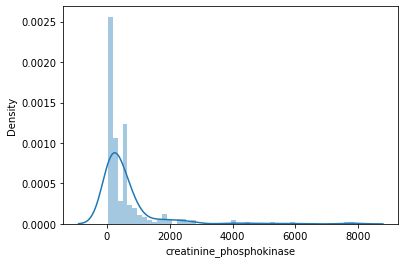

In [13]:
sns.distplot(dataset['creatinine_phosphokinase'])

<AxesSubplot:xlabel='serum_creatinine', ylabel='Density'>

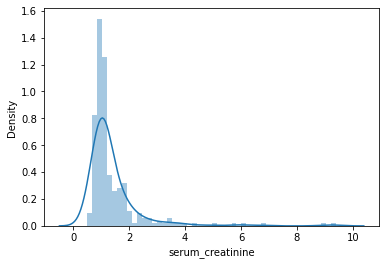

In [14]:
sns.distplot(dataset['serum_creatinine'])

<AxesSubplot:xlabel='platelets', ylabel='Density'>

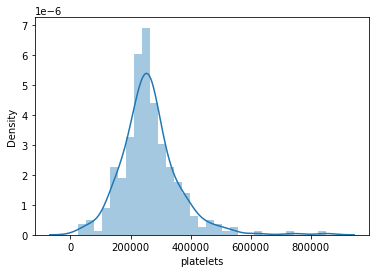

In [15]:
sns.distplot(dataset['platelets'])

<AxesSubplot:xlabel='ejection_fraction', ylabel='Density'>

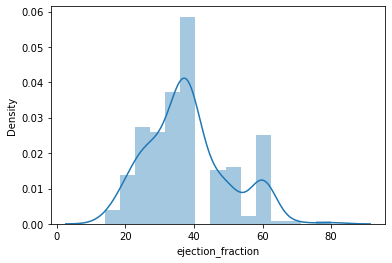

In [16]:
sns.distplot(dataset['ejection_fraction'])

<AxesSubplot:xlabel='age', ylabel='Density'>

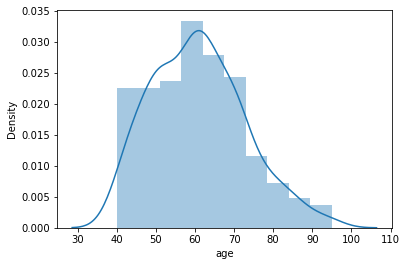

In [17]:
sns.distplot(dataset['age'])

<AxesSubplot:xlabel='serum_sodium', ylabel='Density'>

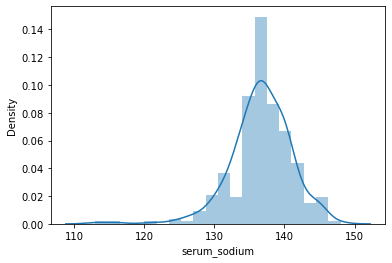

In [18]:
sns.distplot(dataset['serum_sodium'])

<AxesSubplot:xlabel='serum_creatinine', ylabel='Density'>

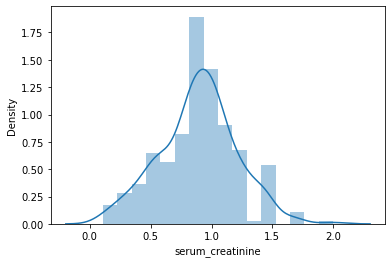

In [19]:
recip = 1/dataset['serum_creatinine']
sns.distplot(recip)

<AxesSubplot:xlabel='creatinine_phosphokinase', ylabel='Density'>

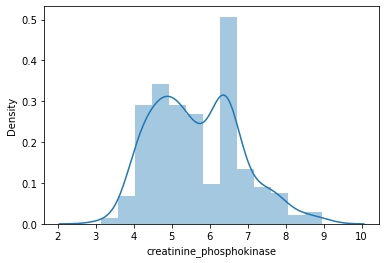

In [20]:
log_var = np.log(dataset['creatinine_phosphokinase'])
sns.distplot(log_var)

In [21]:
#Create a version of serum creatinine that is a reciprocal
dataset['serum_creatinine_recip'] = 1/dataset['serum_creatinine']

##### Feature selection
***

In [22]:
#Use recursive feature elimination to select features.
#Use several different algorithms to help select the best supported features.

#rfe = RFE(DecisionTreeClassifier(),n_features_to_select=5)
#rfe = RFE(AdaBoostClassifier(),n_features_to_select=5)
#rfe = RFE(LogisticRegression(),n_features_to_select=5)
rfe = RFE(RidgeClassifier(),n_features_to_select=5)
rfe.fit(X_train, y_train)
print(rfe.get_support())
print(X_train.columns)

[False False False  True False  True False  True False  True  True False]
Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time'],
      dtype='object')


In [23]:
#Different versions of the dataset to use in the Voting classifier.

RFE_Features = ['time', 'age', 'serum_creatinine_recip', 'ejection_fraction', 'serum_sodium']
Three_Features = ['time','ejection_fraction','serum_creatinine_recip']
X_3 = dataset[Three_Features]
X_RFE = dataset[RFE_Features]
X_no_time = dataset.drop(['DEATH_EVENT', 'time', 'serum_creatinine_recip'], axis=1)
X_all = dataset.drop(['DEATH_EVENT', 'serum_creatinine_recip'], axis=1)

In [24]:
#Create a function to do repeats of the chosen classifier. Input includes the classifier to be used,
#the number of repeats to perform, and the dataset to classify.
#This function will also use SMOTE to oversample the target class.
smote = SMOTE()

def run_smote_model(InClf, repeat, X_in):
    accuracy_agg = 0
    f1_agg = 0
    MCC_agg = 0
    TP_agg = 0
    TN_agg = 0
    ROC_AUC_agg = 0
    PR_AUC_agg = 0
    for x in range(repeat):
        X_train, X_test, y_train, y_test = train_test_split(X_in, y, test_size=0.35, stratify=y)
        
        X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)

        InClf.fit(X_train_smote.values, y_train_smote)
        y_pred = InClf.predict(X_test.values)

        accuracy_agg = accuracy_agg + accuracy_score(y_test, y_pred)
        f1_agg = f1_agg + f1_score(y_test, y_pred)
        MCC_agg = MCC_agg + matthews_corrcoef(y_test, y_pred)
        precision_auc, recall_auc, thresholds = precision_recall_curve(y_test, y_pred)
        PR_AUC_agg = PR_AUC_agg + auc(recall_auc, precision_auc)
        y_roc = InClf.predict_proba(X_test.values)
        y_roc = y_roc[:,1]
        ROC_AUC_agg = ROC_AUC_agg + roc_auc_score(y_test, y_roc)
        
        CM = pd.DataFrame(confusion_matrix(y_test, y_pred))
        TP_agg = TP_agg + CM[1][1] / (CM[1][1] + CM[0][1])
        TN_agg = TN_agg + (CM[0][0]) / (CM[0][0] + CM[1][0])

    print("MCC:", MCC_agg/repeat)
    print("F1 score:", f1_agg/repeat)
    print("Accuracy:", accuracy_agg/repeat)
    print("TP:", TP_agg/repeat)
    print("TN:", TN_agg/repeat)
    print("PR AUC:", PR_AUC_agg/repeat)
    print("ROC AUC", ROC_AUC_agg/repeat)
    print("")

##### Hyperparameter tuning
***

In [25]:
#random forest
clf_object = RandomForestClassifier()

clf_parameters_tested = { 'n_estimators': [25,30,35,40,45,50,55,60],
                         'max_depth': [1,2,5,7,10,15,20,25,30,35,40],
                         'min_samples_split': [2,3,4,5,6,7,8,9,10]
}

clf = RandomizedSearchCV(clf_object, clf_parameters_tested, random_state=0, n_jobs=-1,
                         verbose=10, cv=5, n_iter=2000, scoring='roc_auc')
search = clf.fit(X_train, y_train)
search.best_params_

Fitting 5 folds for each of 792 candidates, totalling 3960 fits


{'n_estimators': 45, 'min_samples_split': 5, 'max_depth': 15}

In [26]:
#adaptive boost
clf_object = AdaBoostClassifier(algorithm='SAMME')

clf_parameters_tested = { 'n_estimators': [5,10,12,13,14,15,16,17,18,20,25,30,35,40,50,75,100],
                         'learning_rate': [0.1, 0.25, 0.5, 0.75, 1, 1.5, 2],
                         'base_estimator': [DecisionTreeClassifier(criterion='gini', min_samples_split=20, min_samples_leaf=int(round(20.0/3.0)), max_depth=30),
                                           DecisionTreeClassifier(),
                                           DecisionTreeClassifier(criterion='entropy', max_depth=1),
                                           GaussianNB()]
}

clf = RandomizedSearchCV(clf_object, clf_parameters_tested, random_state=0, n_jobs=-1,
                         verbose=10, cv=5, n_iter=2000, scoring='roc_auc')
search = clf.fit(X_train, y_train)
search.best_params_

Fitting 5 folds for each of 476 candidates, totalling 2380 fits


{'n_estimators': 25,
 'learning_rate': 0.1,
 'base_estimator': DecisionTreeClassifier(max_depth=30, min_samples_leaf=7, min_samples_split=20)}

In [27]:
#gradient boost
clf_object = GradientBoostingClassifier()

clf_parameters_tested = {'learning_rate': [.001, .01, .1, 1, 10], 
                         'n_estimators': [30,45,60,100],
                         'max_depth': [1,2,5,7,10,20,30,40],
                         'min_samples_split': [2,3,4,5,6,7,8,9,10]
}

clf = RandomizedSearchCV(clf_object, clf_parameters_tested, random_state=0, n_jobs=-1,
                         verbose=10, cv=5, n_iter=2000, scoring='roc_auc')
search = clf.fit(X_train, y_train)
search.best_params_

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


{'n_estimators': 30,
 'min_samples_split': 2,
 'max_depth': 2,
 'learning_rate': 0.1}

In [28]:
#lightboost
clf_object = LGBMClassifier()

clf_parameters_tested = {'learning_rate': [.001, .01, .1, 1, 10], 
                         'n_estimators': [50,100,200,300,400,500,900],
                         'max_depth': [1,2,5,7,10,20,30,40],
                         'reg_alpha': [.001, .01, .1, 1, 10],
                         'reg_lambda': [.001, .01, .1, 1, 10]
}

clf = RandomizedSearchCV(clf_object, clf_parameters_tested, random_state=0, n_jobs=-1,
                         verbose=10, cv=5, n_iter=2000, scoring='roc_auc')
search = clf.fit(X_train, y_train)
search.best_params_

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


{'reg_lambda': 1,
 'reg_alpha': 0.001,
 'n_estimators': 100,
 'max_depth': 40,
 'learning_rate': 0.1}

In [29]:
#bagging

clf_object = BaggingClassifier(n_jobs=-1)

clf_parameters_tested = {'n_estimators': [5,10,12,13,14,15,16,17,18,20,25,30,35,40,50,75,100],
                         'max_samples': [0.1, 0.25, 0.5, 0.75, 1, 1.5, 2],
                         'max_features': [0.1, 0.25, 0.5, 0.75, 1, 1.5, 2],
                         'base_estimator': [DecisionTreeClassifier(criterion='gini', min_samples_split=20, min_samples_leaf=int(round(20.0/3.0)), max_depth=30),
                                           DecisionTreeClassifier(),
                                           DecisionTreeClassifier(criterion='entropy', max_depth=1),
                                           GaussianNB()]
}

clf = RandomizedSearchCV(clf_object, clf_parameters_tested, random_state=0, n_jobs=-1,
                         verbose=10, cv=5, n_iter=2000, scoring='roc_auc')
search = clf.fit(X_train, y_train)
search.best_params_

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


{'n_estimators': 18,
 'max_samples': 0.75,
 'max_features': 0.75,
 'base_estimator': DecisionTreeClassifier(max_depth=30, min_samples_leaf=7, min_samples_split=20)}

In [30]:
#Logistic Regression classifier

clf_object = LogisticRegression()

clf_parameters_tested = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'C': [.001, .01, .1, 1, 2, 5],
                         'tol': [.00001, .0001, .001, .01, .1, 1]
}

clf = RandomizedSearchCV(clf_object, clf_parameters_tested, random_state=0, n_jobs=-1,
                         verbose=10, cv=5, n_iter=2000, scoring='roc_auc')
search = clf.fit(X_train, y_train)
search.best_params_

Fitting 5 folds for each of 144 candidates, totalling 720 fits


{'tol': 1e-05, 'penalty': 'l2', 'C': 0.001}

In [31]:
#K-nearest neighbors classifier

clf_object = KNeighborsClassifier()

clf_parameters_tested = { 'leaf_size': [2,3,4,5,10,15,20,25,30,40,50],
                    'n_neighbors': [2,3,4,5,6,7,8,9,10],
                    'p': [1,2,3,4,5],
                    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

clf = RandomizedSearchCV(clf_object, clf_parameters_tested, random_state=0, n_jobs=-1,
                         verbose=10, cv=5, n_iter=2000, scoring='roc_auc')
search = clf.fit(X_train, y_train)
search.best_params_

Fitting 5 folds for each of 1980 candidates, totalling 9900 fits


{'p': 1, 'n_neighbors': 7, 'leaf_size': 2, 'algorithm': 'auto'}

##### Classifier creation and scoring
***

In [32]:
#Create a bunch of classifiers to use in the Voting ensemble.

# clf1 = RandomForestClassifier(n_estimators=55, min_samples_split=8, max_depth=5)
clf1 = RandomForestClassifier()

# clf2 = GradientBoostingClassifier(n_estimators=100, min_samples_split=6, max_depth=30, learning_rate=1)
clf2 = GradientBoostingClassifier()

# clf3 = XGBClassifier(verbosity=0, booster='dart')
clf3 = xgb.XGBClassifier(max_depth=2, num_round=2, nthread=2, eta=1)

clf4 = LGBMClassifier(max_depth= 20,reg_alpha=0.1, reg_lambda=0.1,learning_rate= 0.01, n_estimators=500, num_leaves=40)
# clf4 = LGBMClassifier()

clf5 = AdaBoostClassifier(learning_rate = .5, n_estimators=17, base_estimator = DecisionTreeClassifier(max_depth=30, min_samples_leaf=7, min_samples_split=20))

clf6 = BaggingClassifier(n_estimators = 18, max_samples=0.75, max_features=0.75, base_estimator=DecisionTreeClassifier(max_depth=30, min_samples_leaf=7, min_samples_split=20))

clf7 = LogisticRegression(C=.1, tol=0.00001)

clf8 = GaussianNB()

clf9 = KNeighborsClassifier(n_jobs=-1, n_neighbors=2, leaf_size=2, p=1)

clf10 = DecisionTreeClassifier()

In [33]:
#Create two versions of the voting classifier.

clf_7_models = VotingClassifier(estimators=[
('rf', clf1)
#, ('GB', clf2)
, ('XGB', clf3)
, ('LGBM', clf4)
, ('Bag',clf6)
, ('LR', clf7)
, ('NB', clf8)
, ('KNN', clf9)
],voting='soft')

clf_5_models = VotingClassifier(estimators=[
('rf', clf1)
#, ('GB', clf2)
, ('XGB', clf3)
, ('LGBM', clf4)
, ('Bag',clf6)
, ('LR', clf7)
# , ('NB', clf8)
# , ('KNN', clf9)
],voting='soft')

In [34]:
#Run models and print results.

print("Results for the three-features dataset.")
run_smote_model(clf_7_models, 100, X_3)
print("")
print("Results for the five-feature RFE feature set.")
run_smote_model(clf_7_models, 100, X_RFE)
print("")
print("Results for the full datset including the time feature.")
run_smote_model(clf_5_models, 100, X_all)
print("")
print("Results for the exact dataset used to generate Table 4.")
run_smote_model(clf_5_models, 100, X_no_time)

Results for the three-features dataset.
MCC: 0.6712849440637376
F1 score: 0.7775223757188683
Accuracy: 0.8532380952380944
TP: 0.795
TN: 0.8811267605633804
PR AUC: 0.8136659485635664
ROC AUC 0.9122825186412594


Results for the five-feature RFE feature set.
MCC: 0.657201962438725
F1 score: 0.769571427316601
Accuracy: 0.8448571428571421
TP: 0.8026470588235297
TN: 0.8650704225352118
PR AUC: 0.8054231911466365
ROC AUC 0.909047224523612


Results for the full datset including the time feature.
MCC: 0.6491693701165997
F1 score: 0.7630226870608664
Accuracy: 0.8436190476190472
TP: 0.7788235294117648
TN: 0.874647887323944
PR AUC: 0.8014036179666327
ROC AUC 0.9127879038939519


Results for the exact dataset used to generate Table 4.
MCC: 0.41202918767626456
F1 score: 0.6060729434919011
Accuracy: 0.7365714285714285
TP: 0.6285294117647058
TN: 0.7883098591549295
PR AUC: 0.6698000950937061
ROC AUC 0.7762386081193039



In [35]:
#Attempt to replicate other researcher's results:

clf = StackingClassifier(estimators=[
('rf', clf2) 
, ('XGB', clf3)
, ('DT', clf10)
], final_estimator = clf1)

run_smote_model(clf, 100, X_RFE)

MCC: 0.5842864885147984
F1 score: 0.7206782437374122
Accuracy: 0.8125714285714284
TP: 0.7476470588235296
TN: 0.8436619718309859
PR AUC: 0.7656427228808002
ROC AUC 0.8659299917149959

